### Building a GPT

In [1]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

Encoding is like a dictionary between numbers and letters:
- ASCII encoding: "A" is 65, "a" is 97. ord() returns the ASCII number, while chr() returns the character
- UTF-8 encoding: can handle all characters in all languages; same ord() and chr() functions. 

In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [6]:
# let's look at the first 100 characters
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [8]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [9]:
# special characters
print((chars[:13]))

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?']


Tokenizers
- SentencePiece by Google: https://github.com/google/sentencepiece
- tiktoken by OpenAI: https://github.com/openai/tiktoken

In [ ]:
# tokenizer: create a mapping from characters to integers (character-level)
# lambda function: lambda arguments: expression
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
print(text[59:63])
print(encode(text[59:63]))

.

A

[8, 0, 0, 13]


In [21]:
# OpenAI tokenizer (sub-word tokenizer)
import tiktoken
enc = tiktoken.get_encoding('gpt2')
print(f'vocab_size: {enc.n_vocab}')
print(enc.encode("hii there"))
print(enc.decode(enc.encode("hii there")))

vocab_size: 50257
[71, 4178, 612]
hii there


In [22]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch 
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100]) # first 100 characters encoded

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [23]:
# let's now split up the data into train and validation datasets
n = int(0.9*len(data)) # first 90% is train data, rest val
train_data = data[:n]
val_data = data[n:]

In [26]:
block_size = 8 # context_length
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [27]:
# [time dimension] multiple examples are packed into each block_size, let's unpack them
# not just for efficiency, but training transformer to infer from context length of 1 to block_size inputs
x = train_data[:block_size]
y = train_data[1:block_size+1]
print(f'inputs: {x}')
print(f'outputs: {y}')
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

inputs: tensor([18, 47, 56, 57, 58,  1, 15, 47])
outputs: tensor([47, 56, 57, 58,  1, 15, 47, 58])
when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


- transformer will never recieve more than 'block_size' inputs during inference, otherwise we need to truncate the inputs to block_size

In [63]:
# [batch dimension]: just for efficiency - process multiple chunks independently at the same time (GPU Parallel Processing)
torch.manual_seed(1337)
batch_size = 4 # how many independent sequence will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

# generate a small batch of data of inputs x and targets y
def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data)-block_size,(batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])
    return x,y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('outputs:')
print(yb.shape) # [4, 8] array contains a total of 32 independent examples for transformer!
print(yb)

print('-----')
print(f'{yb.shape} array contains {yb.shape[0]*yb.shape[1]} independent examples for transformer')
print()

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b,:t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")


inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
outputs:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
-----
torch.Size([4, 8]) array contains 32 independent examples for transformer

when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the targe

In [64]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


#### Bigram language model

- Tokens aren't talking to each other; Just predict the next (T+1) token based on current token (T)

- Typical size of embedding matrix 

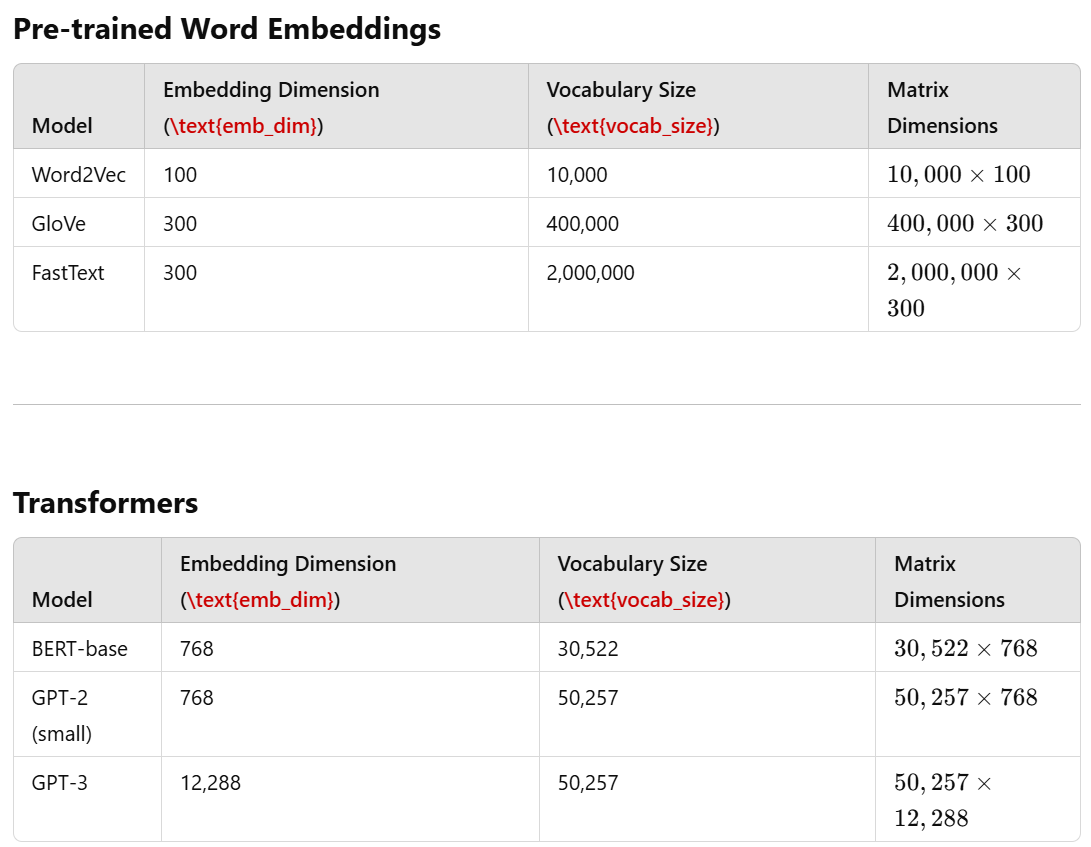

In [75]:
a = torch.rand(2,3,5)
print(a)
a.view(2,-1).shape

tensor([[[0.7615, 0.2538, 0.8664, 0.7528, 0.7263],
         [0.2421, 0.7232, 0.2487, 0.9558, 0.6160],
         [0.6371, 0.5433, 0.8610, 0.0114, 0.0890]],

        [[0.4779, 0.4746, 0.1037, 0.1683, 0.9678],
         [0.8240, 0.9480, 0.6755, 0.1139, 0.2879],
         [0.5597, 0.1363, 0.7405, 0.7476, 0.1182]]])


torch.Size([2, 15])

In [79]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


In [179]:
# Multinomial distribution based on the elements of "a" as probabilities 
a = torch.rand(1,6)
a, torch.multinomial(a, 3)

(tensor([[0.2566, 0.7936, 0.9408, 0.1332, 0.9346, 0.5936]]),
 tensor([[5, 1, 2]]))

In [129]:
import torch 
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
import math

class BigramLanguageModel(nn.Module):

    def __init__(self,vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        # because the emb_dim = vocab_size here. Thus, 
        self.token_embedding_table = nn.Embedding(vocab_size,vocab_size)
    
    def forward(self,idx,targets=None):
        # idx and targets are both (B,T) tensor of integers
        # retrieve's idx-th row from the embedding matrix to get channel dimension
        logits = self.token_embedding_table(idx) # (B, T, C) -> (4,8,65) (batch_size, time, vocab_size)

        if targets is None:
            loss = None
        else:
            # reshape as cross_entropy takes (B,C,dim) i.e., batch_size, channels, other_dims
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T) # targets.view(-1)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context
        # NOTE: there is not limit on T value (context lunch or so), thus you can keep appending new tokens
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx) # calls forward method in subclass of nn.Module; feeds every time-step
            # print(logits.shape) # logits here has (B, T, C) dimensions

            # focus only on the last time step
            logits = logits[:,-1,:] # becomes (B,C) # looks at only last token in bigram model to predict next token
            # print(logits.shape)
            # print(logits)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(probs,num_samples=1) # (B,1)
            # append sampled index to the running sequence
            idx = torch.cat((idx,idx_next), dim=1) # (B,T+1)
            # print(idx.shape)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)

# (Batch, Time, Channel) - Channel dim comes from plucking rows in Embedding Matrix
print(logits.shape) 
print(loss)

# if all tokens probabilities are equal (uniform distribution over the vocabulary)
print(f"uniform distribution loss would be: {-math.log(1/65)}") # vocab_size=65

# produces garbage as this is a random model (random embedding matrix)
print(decode(m.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)
uniform distribution loss would be: 4.174387269895637

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [130]:
# create a PyTorch optimizer object
optimizer = torch.optim.AdamW(m.parameters(),lr=1e-3)

In [139]:
batch_size = 32
for steps in range(10000):

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.4113707542419434


In [140]:
# NOTE: different outputs everytime I run this as randomness is introduced by "torch.multinomial"
print(decode(m.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=300)[0].tolist()))


He:
Anghey seo wes.
That.


Thateleriss mire, wiverito s misefethe atosund musfor ile coupth The:
Thm'd b:
TENNGHINApe throul bllangubesind.
AROnsu ds pst,
LABENous t spo aceas haulyoul tchotots fe ndikesindy outoueen

QUS:
APr'h CHesarefof?

Jot bangulirorouthonge RELALendst whanke e othatan mowr b


### The mathematical trick in self-attention

In [142]:
# consider the following toy example:
import torch

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [150]:
# tokens communication: information flows only from previous tokens to the current time-step.
#                       cannot get any information from the future.

# Approach 1: just average the embeddings from past tokens + current token: losses spatial arrangements. 

# version 1: using for loops
# we want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C)) # bow: bag of words
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev,0)

# print(x[0])
# print(xbow[0])

-  Use Matrix Multiplication instead of for loops

In [173]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a0 = torch.ones(3,3)
b = torch.randint(0,10,(3,2)).float()
c0 = a0 @ b # matrix multiplication (a*b: element wise)
print(a0)
print(b)
print(c0)
print("-----")
a = torch.tril(torch.ones(3,3))
print(torch.sum(a, 1, keepdim=True).shape)
print(torch.sum(a, 1, keepdim=True))
print(torch.sum(a, 1, keepdim=False))
a = a / torch.sum(a, 1, keepdim=True) # element-wise divison by "/" operation
c = a @ b
a, b, c

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])
-----
torch.Size([3, 1])
tensor([[1.],
        [2.],
        [3.]])
tensor([1., 2., 3.])


(tensor([[1.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000],
         [0.3333, 0.3333, 0.3333]]),
 tensor([[2., 7.],
         [6., 4.],
         [6., 5.]]),
 tensor([[2.0000, 7.0000],
         [4.0000, 5.5000],
         [4.6667, 5.3333]]))

In [178]:
# version 2: using matrix multiplication for a weighted aggregation
wei = torch.tril(torch.ones(T,T)) # "wei" for weights
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # ('B', T, T) @ (B, T, C) --> (B, T, C); Broadcasted 'B' here
# print(wei)
print(xbow[0],xbow2[0])
print(torch.allclose(xbow,xbow2, atol=1e-7))

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]]) tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])
True


***Tricks for self-attention***
- weighted aggregation of past elements by using matrix mul of lower triangular fashion
- elements in lower triangular part indicate how much of each element fuses into this positon

In [182]:
wei = torch.zeros(T,T)
tril = torch.tril(torch.ones(T,T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [195]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T)) # begins with zero (interaction strength/affinity) --> token weights? how much of past tokens need to aggregate or avg. up?
wei = wei.masked_fill(tril==0, float('-inf')) # tokens from future cannot communicate with past by setting them to '-inf'
print(f"Weights: \n {wei}")
wei = F.softmax(wei, dim=1) # softmax is a normalization --> gives similar weight matrix as above 'wei'
print(f"Weights: \n {wei}")
xbow3 = wei @ x
print(wei.shape, x.shape, xbow3.shape)
print(xbow3[0])

Weights: 
 tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
Weights: 
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.

In [219]:
# math trick
B, T, C = 4, 8, 2
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros(T,T)
wei = wei.masked_fill(tril==0,float('-inf'))
wei = wei.softmax(dim=1)
x = torch.randn(B, T, C)
x_bow = wei @ x
x_bow.shape

torch.Size([4, 8, 2])

#### Self-attention

- every single token/node at each position will emit two vectors: query, key
- query: what am I looking for?
- key: what do I contain?
- affinities: dot product of keys & queries
- my query dot products with all the keys of all the other tokens --> wei
- if key and query are aligned --> high dot product. Learn more from that token opposed to any other token in the sequence. 
- previously 'wei' was constant across batches; now 'wei' is different for each batch -> data-dependent
- higher 'wei' value for prev tokens means, that token has high affinity with the current token (at row-th position) & agg. more info from that token to current token/my position
- v (value) is the thing that gets aggregated for the purposes of this single head

In [ ]:
# version 4: without self-attention
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels: (4,8) tokens with info at each token - 32 dim's
x = torch.randn(B,T,C)

tril = torch.tril(torch.ones(T,T))
wei = torch.zeros(T,T) # affinities btwn different tokens initialized to be zeros (uniform) --> uniform nums in wei after softmax
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1) # (T, T) uniform weights aggregation
out = wei @ x

print(wei)
print(wei.shape)

out.shape

In [ ]:
# version 4: self-attention! for a single individual head
# checking raw wei values

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels: (4,8) tokens with info at each token - 32 dim's
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2,-1) # (B, T, 16) @ (B, 16, T) --> (B, T, T)

tril = torch.tril(torch.ones(T,T))
# wei = torch.zeros(T,T) # affinities btwn different tokens initialized to be zeros (uniform) --> uniform nums in wei after softmax
wei = wei.masked_fill(tril==0, float('-inf'))
# wei = F.softmax(wei, dim=-1) # (B, T, T) weighted aggregation: non-uniform weights
out = wei @ x

# previously 'wei' was constant across batches; now 'wei' is different for each batch -> data-dependent
print('raw wei outputs: \n', wei[0])

out.shape

single head:
- key: what do I contain?
- affinities: dot product of keys & queries
- v (value) is the thing that gets aggregated for the purposes of this single head between the different nodes

In [ ]:
# version 4: self-attention! for a single individual head

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels: (4,8) tokens with info at each token - 32 dim's
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
# all the tokens in (B,T) in parallel & independently produce a key (k), query (q) above. No communication btwn tokens till now. 
# weighted aggregation (wei) is a function of data-dependent keys & queries 
wei = q @ k.transpose(-2,-1) # (B, T, 16) @ (B, 16, T) --> (B, T, T)

tril = torch.tril(torch.ones(T,T))
# wei = torch.zeros(T,T) # affinities btwn different tokens initialized to be zeros (uniform) --> uniform nums in wei after softmax
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1) # (B, T, T) weighted aggregation: non-uniform weights

# out = wei @ x # (B, T, T) @ (B, T, C) --> (B, T, C)
v = value(x) # (B, T, 16)
out = wei @ v # (B, T, 16)

# previously 'wei' was constant across batches; now 'wei' is different for each batch -> data-dependent
print(wei[0])

out.shape # batch, time, head_size

***Few notes about attention mechanism:***
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- attention can be applied to any arbitrary directed graph - just a communication mechanism between the nodes. 
- Understand positional encoding more clearly

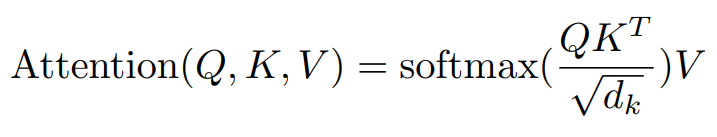

In [ ]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2,-1) * head_size**-0.5

In [ ]:
k.var()

In [ ]:
q.var()

In [ ]:
wei.var()

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

In [ ]:
# Layernorm over last-dimension

import torch
import torch.nn as nn
torch.manual_seed(123)

# Define the model with layer normalization
n_embd = 4  # size of each token's feature
ln = nn.LayerNorm(n_embd)

# Example input tensor (batch_size = 2, seq_length = 3, n_embd = 4)
x = torch.randn(2, 3, 4)
print(x)
print()

# Apply layer normalization
output = ln(x)
print(output)


In [ ]:
# Layernorm over last two dimensions
import torch
import torch.nn as nn
torch.manual_seed(123)

# Define the model with layer normalization
n_embd = 4  # size of each token's feature
ln = nn.LayerNorm((3,4))

# Example input tensor (batch_size = 2, seq_length = 3, n_embd = 4)
x = torch.randn(2, 3, 4)
print(x)
print()

# Apply layer normalization
output = ln(x)
print(output)


In [ ]:
0.7853  -0.0181 -0.2142 -0.6578 +0.8028 +  1.2889 -0.0834 -0.3321+ 0.0088 -0.3669+  1.3441 -2.5573

In [ ]:
12288/96